In [1]:
import numpy as np
import scipy.stats as scistats
import scipy.integrate as sciintg
import scipy.io as io
from matplotlib import pyplot as plt

# Problem 1

Consider the following mixture distribution
\begin{equation}
p(x) = 0.4 \cdot \mathcal{N}(x \vert 0, 1^2) + 0.6 \cdot L(x \vert 5, 2),
\end{equation}
where $\mathcal{N}(x \vert 0, 1^2)$ is a Gaussian distribution with a mean of zero and a variance of $1^2$, and $L(x \vert 5, 2)$ is a Laplacian distribution with a location of 5 and a scaling parameter of 2.

## Q1a) Plot the distribution

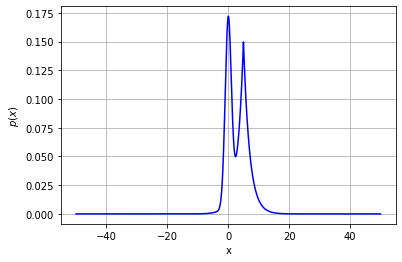

In [2]:
class mixture_dist(object):
    
    #Global object methods
    _gauss = scistats.norm(loc = 0, scale = 1)
    _laplace = scistats.laplace(loc = 5, scale = 2)
    
    def pdf(self, x):

        return 0.4 * self._gauss.pdf(x) + 0.6 * self._laplace.pdf(x)

x_range = np.linspace(-50, 50, 10000)
mixture_instance = mixture_dist()
y_range = mixture_instance.pdf(x_range)

plt.figure()
plt.plot(x_range, y_range, "b")
plt.xlabel("x")
plt.ylabel(r"$p(x)$")
plt.grid()
plt.savefig("./images/Q1a.pdf")
plt.show()

## Q1b) Is $p(x)$ a valid PDF?

In [3]:
print("Yes, pretty easy to say from the PDF form.")

print(sciintg.trapezoid(y_range, x_range))

Yes, pretty easy to say from the PDF form.
0.9999993935780693


## Q1c) Draw samples from the distribution using rejection sampling and check the accuracy of the model. Investigate different proposal distributions and scaling choices. Motivate your choices and summarise the results of the inference procedure (e.g. histogram of the samples, efficiency of the sampling process).

- Initialise a proposal distribution $q(x)$.
- Define/find a scale $k$ such that $k \cdot q(x) > \tilde{p}(x)$ $\forall x$.
- Draw a sample $x_i \sim q(x)$.
- Evaluate $q(x_i)$ and $\tilde{x}(x_i)$.
- Sample from a uniform distribution $u_i \sim U[0, 1]$.
- Accept if $\frac{\tilde{p}(x_i)}{k \cdot q(x_i)} > u_i$, reject otherwise (alternatively, if $\tilde{p}(x_i) > u_i \cdot k \cdot q(x_i)$).
- Repeat until a suitable number of samples is drawn.

In [4]:
def rejection_sampler(n_samples, unnorm_dist, proposal_dist, domain_range = [-50, 50], K = None, max_iter = 1000, visualise = False):
    
    #Initialise range
    x_range = np.linspace(domain_range[0], domain_range[1], 10000)
    q_x = proposal_dist.pdf(x_range)
    p_x = unnorm_dist.pdf(x_range)
        
    if K is None:
        
        k_init = 0
        k_iter = 0.1
        
        check_flag = False
        
        cnt_while = 0
        while not check_flag and cnt_while < max_iter:
            
            if np.sum(k_init * q_x / p_x < 1) == 0:
                
                K = k_init
                check_flag = True
            
            else:
                k_init += k_iter
                cnt_while += 1
        
        if cnt_while == max_iter:
            print("Hit iteration cap ({} iterations)".format(cnt_while))
            raise SystemExit
        
        else:
            print("Optimal K: {}".format(K))
    
    #Check the K-value
    try:
        assert np.sum((K * q_x / p_x) < 1) == 0

    except AssertionError:
        print("The K-value used is not sufficient to ensure that k.q(x) > p(x) across the whole domain.")
        raise SystemExit
    
    if visualise:
        plt.figure()
        plt.plot(x_range, K * q_x)
        plt.plot(x_range, p_x, label = r"$p(x)$")
        plt.plot(x_range, K * q_x, label = r"$k \cdot q(x)$")
        plt.legend()
        plt.xlabel(r"$x$")
        plt.show()
    
    #perform rejection sampling
    
    samples = np.zeros(n_samples)
    cnt_drawn = 0
    cnt_samples = 0
    
    while cnt_samples < n_samples:
        
        #Sample from proposal
        x_i = proposal_dist.rvs(1)[0]
        u_i = np.random.random(1)[0]

        #determine q(x_i) and p(x_i)
        q_i = proposal_dist.pdf(x_i)
        p_i = unnorm_dist.pdf(x_i)
        
        r_i = p_i / (K * q_i)
        
        if r_i > u_i:
            samples[cnt_samples] = x_i
            cnt_samples += 1
        
        cnt_drawn += 1
    
    efficiency = cnt_samples / cnt_drawn * 100
    
    return samples, efficiency, K
    
    
    

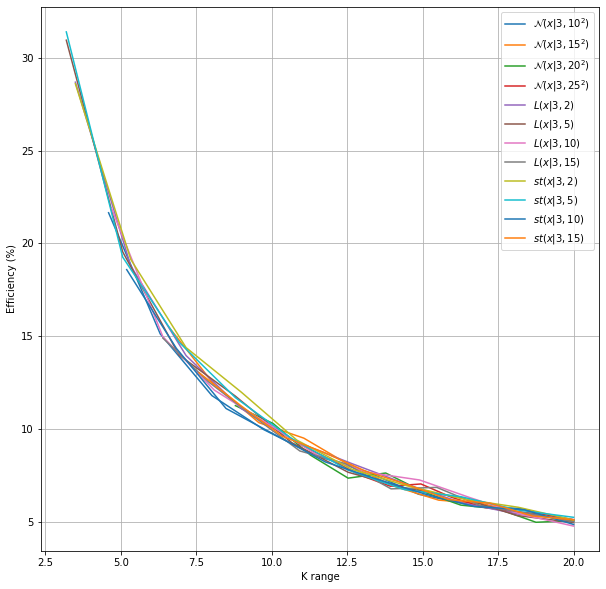

In [5]:
x_range = np.linspace(-10, 20, 50000)
mixture_instance = mixture_dist()
y_range = mixture_instance.pdf(x_range)

proposal_1 = scistats.norm(3, 10)
proposal_2 = scistats.norm(3, 15)
proposal_3 = scistats.norm(3, 20)
proposal_4 = scistats.norm(3, 25)
proposal_5 = scistats.laplace(3, 2)
proposal_6 = scistats.laplace(3, 5)
proposal_7 = scistats.laplace(3, 10)
proposal_8 = scistats.laplace(3, 15)
proposal_9 = scistats.t(loc = 3, scale = 2, df = 2)
proposal_10 = scistats.t(loc = 3, scale = 5, df = 2)
proposal_11 = scistats.t(loc = 3, scale = 10, df = 2)
proposal_12 = scistats.t(loc = 3, scale = 15, df = 2)

proposal_dists = [proposal_1, 
                  proposal_2, 
                  proposal_3, 
                  proposal_4, 
                  proposal_5, 
                  proposal_6, 
                  proposal_7, 
                  proposal_8, 
                  proposal_9, 
                  proposal_10, 
                  proposal_11, 
                  proposal_12]

K_vals = [4.6, 6.6, 8.8, 10.9, 3.5, 3.2, 4.7, 6.4, 3.5, 3.2, 5.2, 7.6]
K_limit = 20

prop_labels = [r'$\mathcal{N}(x \vert 3, 10^2)$',
               r'$\mathcal{N}(x \vert 3, 15^2)$',
               r'$\mathcal{N}(x \vert 3, 20^2)$',
               r'$\mathcal{N}(x \vert 3, 25^2)$',
               r'$L(x \vert 3, 2)$', 
               r'$L(x \vert 3, 5)$',
               r'$L(x \vert 3, 10)$',
               r'$L(x \vert 3, 15)$',
               r'$st(x \vert 3, 2)$',
               r'$st(x \vert 3, 5)$',
               r'$st(x \vert 3, 10)$',
               r'$st(x \vert 3, 15)$']

eff_dists = []

fig, ax = plt.subplots(figsize = (10, 10))

cnt = 0

for prop_dist, k_start in zip(proposal_dists, K_vals):
    
    k_iter = np.linspace(k_start, K_limit, 10)
    eff_iter = []
    
    for k_val in k_iter:
        
        _, eff, _ = rejection_sampler(1000, 
                                     mixture_instance, 
                                     prop_dist, 
                                     domain_range = [-50, 50], 
                                     K = k_val, 
                                     max_iter = 1000, 
                                     visualise = False)
    
        eff_iter.append(eff)
    
    ax.plot(k_iter, eff_iter, label = prop_labels[cnt])
    
    cnt += 1

ax.set_xlabel("K range")
ax.set_ylabel("Efficiency (%)")
ax.grid()
ax.legend()
plt.savefig("./images/Q1c.pdf")
plt.show()

#plt.figure()
#plt.title("Rejection sampling efficiency: {:.2f}%".format(eff))
#plt.hist(samples, bins = 50, density = True)
#plt.plot(x_range, y_range, "b")
#plt.xlabel("x")
#plt.ylabel(r"$p(x)$")
#plt.show()

Optimal K: 3.2000000000000015


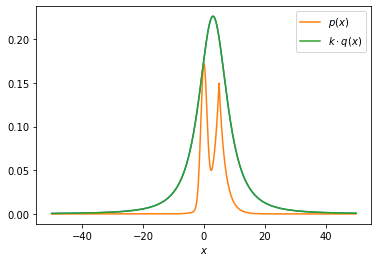

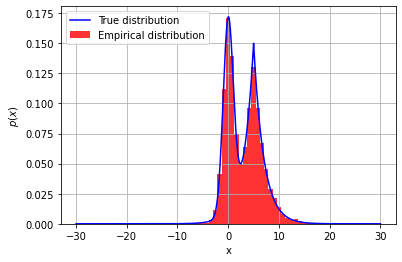

In [62]:
proposal_dist = scistats.t(loc = 3, scale = 5, df = 2)

samples, eff, _ = rejection_sampler(10000, 
                              mixture_instance, 
                              proposal_dist, 
                              domain_range = [-50, 50], 
                              K = None, 
                              max_iter = 1000, 
                              visualise = True)


x_range = np.linspace(-30, 30, 10000)
y_range = mixture_instance.pdf(x_range)

plt.figure()
plt.plot(x_range, y_range, "b", label = "True distribution")
plt.hist(samples, bins = 40, density = True, color = "r", alpha = 0.8, label = "Empirical distribution")
plt.xlabel("x")
plt.ylabel(r"$p(x)$")
plt.grid()
plt.legend()
plt.savefig("./images/Q1c_2.pdf")
plt.show()

In [63]:
eff, _

(31.73696404201974, 3.2000000000000015)

## Q1d) Estimate $\mathbb{E}_{x \sim p(x)} \{ x^2 \}$ using the samples obtained with rejection sampling. Include sufficient evidence of the calculation process

In [65]:
E = np.mean(samples**2)
print(E)

x_range = np.linspace(-50, 50, 100000)
y_range = mixture_instance.pdf(x_range)
print(sciintg.trapezoid(x_range**2 * y_range, x_range))

20.527072582045484
20.19999971005236


## Q1e) Estimate $P(x > 5 \vert x)$ using the samples obtained with rejection sampling. Include sufficient evidence of the calculation process.

In [68]:
P = 1 - np.mean((samples <= 5))
print(P)

x_range = np.linspace(-50, 5, 100000)
y_range = mixture_instance.pdf(x_range)
print(1 - sciintg.trapezoid(y_range, x_range))



0.30369999999999997
0.30000011277038285


## Q1f) Estimate the third percentile of x using the samples obtained with rejection sampling. Include sufficient evidence of the calculation process.

In [83]:
np.percentile(samples, 3)

#Numerically
x_range = np.linspace(-50, 50, 100000)
y_range = mixture_instance.pdf(x_range)
percentage = []

x_iter_range = np.linspace(-40, 50, 1000)
for x_iter in x_iter_range:
    x_range = np.linspace(-50, x_iter, 100000)
    y_range = mixture_instance.pdf(x_range)
    percentage.append(sciintg.trapezoid(y_range, x_range))

pos = np.argmin(np.abs(np.array(percentage) - 0.03))
print(x_iter_range[pos])

[5.041494013304393e-11, 5.2753564988729394e-11, 5.519994193634028e-11, 5.7759035651287106e-11, 6.043603955629656e-11, 6.323638636094111e-11, 6.61657590867737e-11, 6.923010260044883e-11, 7.243563567822841e-11, 7.578886362636318e-11, 7.9296591482954e-11, 8.296593782809282e-11, 8.68043492303011e-11, 9.081961535859244e-11, 9.5019884790818e-11, 9.941368155038659e-11, 1.0400992240490804e-10, 1.088179349618773e-10, 1.1384747659811029e-10, 1.1910875426135992e-10, 1.2461244518428445e-10, 1.3036971855281793e-10, 1.3639225817290397e-10, 1.4269228618160563e-10, 1.4928258785069674e-10, 1.5617653753308622e-10, 1.6338812580471481e-10, 1.7093198785702318e-10, 1.7882343319759292e-10, 1.8707847671925385e-10, 1.957138712006896e-10, 2.0474714130451836e-10, 2.1419661914182377e-10, 2.24081481475332e-10, 2.344217886367128e-10, 2.4523852523700644e-10, 2.565536427527703e-10, 2.6839010407439435e-10, 2.8077193010696517e-10, 2.937242485182794e-10, 3.072733447329042e-10, 3.214467152758051e-10, 3.3627312357376323e-

## Q1g) How does the number of samples impact the accuracy of the aforementioned estimates?

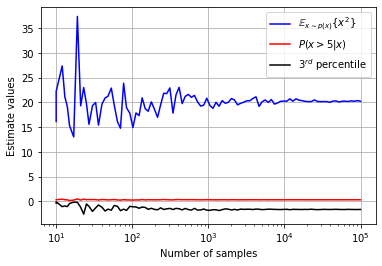

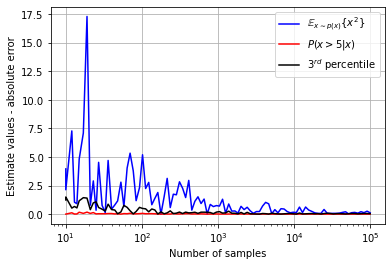

In [85]:
proposal_dist = scistats.t(loc = 3, scale = 5, df = 2)

sample_range = np.logspace(1, 5, 100, dtype = np.int32)

estimate_mat = np.zeros((100, 3))

for cnt, n_samples in enumerate(sample_range):
    
    samples, eff, _ = rejection_sampler(n_samples, 
                                  mixture_instance, 
                                  proposal_dist, 
                                  domain_range = [-50, 50], 
                                  K = 3.2, 
                                  max_iter = 1000, 
                                  visualise = False)
    
    estimate_mat[cnt, 0] = np.mean(samples**2)
    estimate_mat[cnt, 1] = 1 - np.mean((samples <= 5))
    estimate_mat[cnt, 2] = np.percentile(samples, 3)

plt.figure()
plt.semilogx(sample_range, estimate_mat[:, 0], color = "b", label = r"$\mathbb{E}_{x \sim p(x)} \{ x^2 \}$")
plt.semilogx(sample_range, estimate_mat[:, 1], color = "r", label = r"$P(x > 5 \vert x)$")
plt.semilogx(sample_range, estimate_mat[:, 2], color = "k", label = r"$3^{rd}$ percentile")
plt.xlabel("Number of samples")
plt.ylabel("Estimate values")
plt.legend()
plt.savefig("./images/Q1g_1.pdf")
plt.grid()

plt.figure()
plt.semilogx(sample_range, np.abs((estimate_mat[:, 0] - 20.12)), color = "b", label = r"$\mathbb{E}_{x \sim p(x)} \{ x^2 \}$")
plt.semilogx(sample_range, np.abs((estimate_mat[:, 1] - 0.3)), color = "r", label = r"$P(x > 5 \vert x)$")
plt.semilogx(sample_range, np.abs((estimate_mat[:, 2] - (-1.6216))), color = "k", label = r"$3^{rd}$ percentile")
plt.xlabel("Number of samples")
plt.ylabel("Estimate values - absolute error")
plt.legend()
plt.savefig("./images/Q1g_2.pdf")
plt.grid()

In [12]:
np.logspace(1, 5, 100, dtype = np.int32)

array([    10,     10,     12,     13,     14,     15,     17,     19,
           21,     23,     25,     27,     30,     33,     36,     40,
           44,     48,     53,     58,     64,     70,     77,     84,
           93,    102,    112,    123,    135,    148,    162,    178,
          196,    215,    236,    259,    284,    312,    343,    376,
          413,    453,    497,    546,    599,    657,    722,    792,
          869,    954,   1047,   1149,   1261,   1384,   1519,   1668,
         1830,   2009,   2205,   2420,   2656,   2915,   3199,   3511,
         3853,   4229,   4641,   5094,   5590,   6135,   6734,   7390,
         8111,   8902,   9770,  10722,  11768,  12915,  14174,  15556,
        17073,  18738,  20565,  22570,  24770,  27185,  29836,  32745,
        35938,  39442,  43287,  47508,  52140,  57223,  62802,  68926,
        75646,  83021,  91116, 100000])

# Problem 2

Consider the generative model
\begin{equation}
x_n = \theta + \epsilon_n,
\end{equation}
where $\epsilon_n$ is a Laplacian distribution with a known scale parameter of $2$ and a location of $0$, $\epsilon \sim L(\epsilon \vert 0, 2)$. The population parameter $\theta$ is three and not known during the inference process. Use the following measured data to infere the posterior distribution over the unknown parameter:

\begin{equation}
\mathbf{x} = [4.171206 , 3.06754327, 2.16931111, 2.00839214, 4.10014516, 3.51408053, 2.86609886,
6.3492669 , 2.90566741, 5.99086803]^T
\end{equation}

In this problem, Markov Chain Monte Carlo (MCMC) will be used to sample from the posterior distribution over the unknown parameter. Use a Gaussian prior with a mean of 0 and a variance of 25. The model evidence cannot be used in this problem, and only the unnormalised posterior may be used.

In [86]:
Q2_data = np.array([4.171206 , 3.06754327, 2.16931111, 2.00839214, 4.10014516, 3.51408053, 2.86609886,
6.3492669 , 2.90566741, 5.99086803])

print(Q2_data)

[4.171206   3.06754327 2.16931111 2.00839214 4.10014516 3.51408053
 2.86609886 6.3492669  2.90566741 5.99086803]


## Q2a) Provide the mathematical form of the prior, the likelihood function and the unnormalised posterior distribution and include plots of them.

The prior:
\begin{equation}
\begin{aligned}
p(\theta) &= \mathcal{N}(\theta \vert \theta_0, \sigma_0^2) \\
&= \frac{1}{\sqrt{2 \cdot \pi \cdot \sigma_0^2}} \exp \left( -\frac{1}{2 \cdot \sigma_0^2} \cdot \left( \theta - \theta_0 \right)^2 \right),
\end{aligned}
\end{equation}
where $\theta_0 = 0$ and $\sigma_0 = 5$.

The model likelihood:
\begin{equation}
\begin{aligned}
p(x \vert \theta) = L(x \vert \theta, b)
&= \frac{1}{2 \cdot b} \cdot \exp \left( -\frac{\vert x - \theta \vert}{b} \right),
\end{aligned}
\end{equation}
gives rise to the likelihood function
\begin{equation}
\begin{aligned}
p(\mathbf{x} \vert \theta) &= \prod_{n=1}^{N} p(x_n \vert \theta) \\
\mathcal{L}(\theta \vert \mathbf{x}, b) &= \prod_{n=1}^{N} \frac{1}{2 \cdot b} \cdot \exp \left( -\frac{\vert x_n - \theta \vert}{b} \right),
\end{aligned}
\end{equation}

The unnormalised posterior is given by:
\begin{equation}
\begin{aligned}
p(\theta, \mathbf{x}) &= p(\mathbf{x} \vert \theta) p(\theta) \\
F(\theta \vert \theta_0, \sigma_0, \mathbf{x}, b) &=  \frac{1}{\sqrt{2 \cdot \pi \cdot \sigma_0^2}} \exp \left( -\frac{1}{2 \cdot \sigma_0^2} \cdot \left( \theta - \theta_0 \right)^2 \right) \prod_{n=1}^{N} \frac{1}{2 \cdot b} \cdot \exp \left( -\frac{\vert x_n - \theta \vert}{b} \right),
\end{aligned}
\end{equation}

## Q2 b) Plot the unnormalised posterior distribution.

In [87]:
def prior(theta, theta_0, sigma_0):
    
    p1 = 1 / np.sqrt(2 * np.pi * sigma_0**2)
    p2 = np.exp(-1/ (2 * sigma_0**2) * (theta - theta_0)**2)
    
    
    return p1 * p2

def log_prior(theta, theta_0, sigma_0):
    
    p1 = -1/2 * np.log(2 * np.pi) 
    p2 = -1/2 * np.log(sigma_0**2)
    p3 = -1/ (2 * sigma_0**2) * (theta - theta_0)**2
    
    return p1 + p2 + p3

def generative_model(x, theta, b):
    
    p1 = 1/(2 * b)
    p2 = np.exp( -1/b * np.abs(x - theta))
    
    return p1 * p2

def log_generative_model(x, theta, b):
    
    p1 = - np.log(2 * b)
    p2 = -1/b * np.abs(x - theta)
    
    return p1 + p2

def likelihood_function(X, theta, b):
    
    individual_likelihoods = generative_model(X, theta, b)
    
    return np.product(individual_likelihoods)

def log_likelihood_function(X, theta, b):
    
    individual_log_likelihoods = log_generative_model(X, theta, b)
    
    return np.sum(individual_log_likelihoods)

def unnormalised_posterior(X, theta, theta_0, sigma_0, b):
    
    return prior(theta, theta_0, sigma_0) * likelihood_function(X, theta, b)

def log_unnormalised_posterior(X, theta, theta_0, sigma_0, b):
    
    return log_prior(theta, theta_0, sigma_0) + log_likelihood_function(X, theta, b)

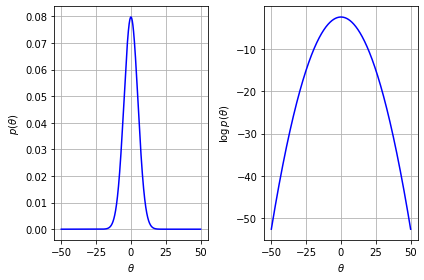

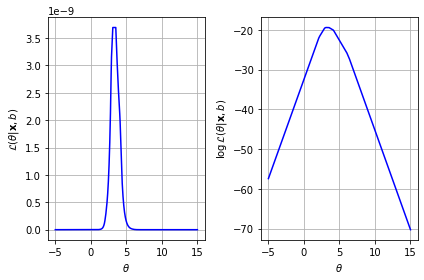

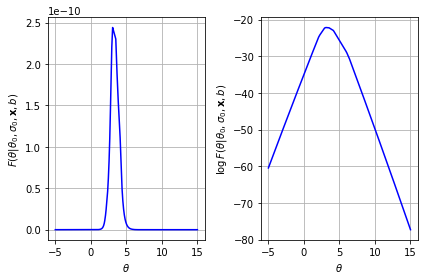

In [90]:
theta_0 = 0
sigma_0 = 5
b = 2

x_range = np.linspace(-10, 10, 10000)
theta_range = np.linspace(-50, 50, 10000)

prior_range = prior(theta_range, theta_0, sigma_0)
log_prior_range = log_prior(theta_range, theta_0, sigma_0)

fig, ax = plt.subplots(1, 2)
#fig.suptitle("The prior")
ax = ax.flatten()

ax[0].plot(theta_range, prior_range, color = "b")
ax[1].plot(theta_range, log_prior_range, color = "b")

ax[0].set_ylabel(r"$p(\theta)$")
ax[1].set_ylabel(r"$\log p(\theta)$")

for axs in ax:
    axs.set_xlabel(r"$\theta$")
    axs.grid()
    
fig.tight_layout()
plt.savefig("./images/Q2b_1.pdf")
plt.show()

#######################
#Likelihood function + unnormalised posterior
#######################

theta_range = np.linspace(-5, 15, 10000)
lf_range = np.zeros(len(theta_range))
llf_range = np.zeros(len(theta_range))
up_range = np.zeros(len(theta_range))
lup_range = np.zeros(len(theta_range))

for cnt, theta in enumerate(theta_range):
    
    lf_range[cnt] = likelihood_function(Q2_data, theta, b)
    llf_range[cnt] = log_likelihood_function(Q2_data, theta, b)
    up_range[cnt] = unnormalised_posterior(Q2_data, theta, theta_0, sigma_0, b)
    lup_range[cnt] = log_unnormalised_posterior(Q2_data, theta, theta_0, sigma_0, b)

fig, ax = plt.subplots(1, 2)
#fig.suptitle("The likelihood function")
ax = ax.flatten()

ax[0].plot(theta_range, lf_range, color = "b")
ax[1].plot(theta_range, llf_range, color = "b")

ax[0].set_ylabel(r"$\mathcal{L}(\theta \vert \mathbf{x}, b)$")
ax[1].set_ylabel(r"$\log \mathcal{L}(\theta \vert \mathbf{x}, b)$")

for axs in ax:
    axs.set_xlabel(r"$\theta$")
    axs.grid()
    
fig.tight_layout()
plt.savefig("./images/Q2b_2.pdf")
plt.show()

fig, ax = plt.subplots(1, 2)
#fig.suptitle("The unnormalised posterior")
ax = ax.flatten()

ax[0].plot(theta_range, up_range, color = "b")
#ax[0].plot(theta_range, np.exp(lup_range), "k--")
ax[1].plot(theta_range, lup_range, color = "b")

ax[0].set_ylabel(r"$F(\theta \vert \theta_0, \sigma_0, \mathbf{x}, b)$")
ax[1].set_ylabel(r"$\log F(\theta \vert \theta_0, \sigma_0, \mathbf{x}, b)$")

for axs in ax:
    axs.set_xlabel(r"$\theta$")
    axs.grid()
    
fig.tight_layout()
plt.savefig("./images/Q2b_3.pdf")
plt.show()

## Q2 c) Use MCMC to sample from the posterior distribution. Document the process. Check the accuracy of the results.

Distinction part: Investigate different proposal distributions. Motivate the choice of your proposal distribution and associated parameters. Summarise the results (e.g. acceptance ratio).

In [16]:
def MCMC(n_iter, X, theta_start, theta_0, sigma_0, b, proposal_distribution, proposal_scale, met_hastings = False, warming_period = 0.5, M_thinning = 5, visualise = False):
    
    #Sample a proposal value for warming up
    theta_i = theta_start
    samples = np.zeros(n_iter)
    n_accept = 0
    
    for i in range(n_iter):
        #Sample from the proposal distribution
        theta_prop = proposal_distribution.rvs(loc = theta_i, scale = proposal_scale, size = 1)[0]
        
        #Determine the Acceptance probability
        
        p_i = unnormalised_posterior(X, theta_i, theta_0, sigma_0, b)
        p_prop = unnormalised_posterior(X, theta_prop, theta_0, sigma_0, b)
        
        if met_hastings:
            
            q_i = proposal_distribution.pdf(theta_i, loc = theta_prop, scale = proposal_scale)
            q_prop = proposal_distribution.pdf(theta_prop, loc = theta_i, scale = proposal_scale)
            
            r1 = p_prop / p_i
            r2 = q_i / q_prop
            
            r = r1 * r2
        
        else:
            r = p_prop / p_i
        
        #print(r)
        A_i = np.min([1, r])

        if A_i > np.random.random():
            theta_i = theta_prop
            n_accept += 1

        samples[i] = theta_i
    
    if visualise:
        plt.figure()
        plt.plot(samples)
        plt.show()
        
    #Adjust for warming
    samples = samples[int(len(samples) * warming_period):]
        
    #Perform thinning
    samples = samples[np.arange(0, len(samples), M_thinning)]
    
    return samples, n_accept / n_iter


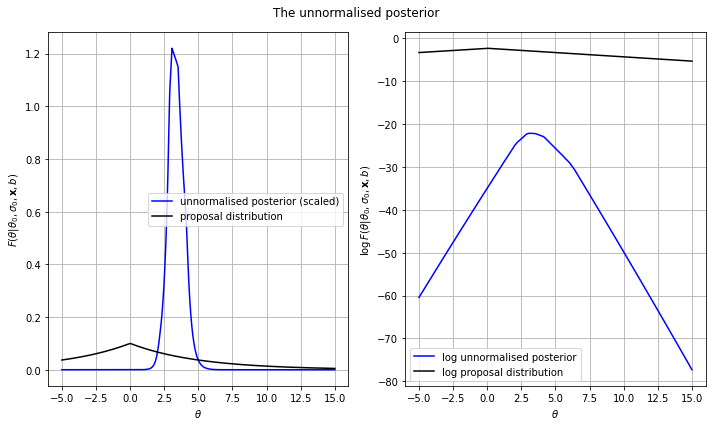

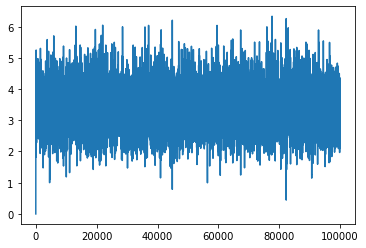

0.15875


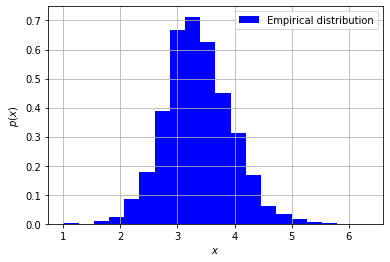

In [122]:
theta_0 = 0
sigma_0 = 5
b = 2

proposal_distribution = scistats.laplace#scistats.norm#
proposal_scale = 5
n_iter = 100000
theta_start = 0

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
fig.suptitle("The unnormalised posterior")
ax = ax.flatten()

ax[0].plot(theta_range, up_range * 0.5e10, color = "b", label = "unnormalised posterior (scaled)")
ax[0].plot(theta_range, proposal_distribution.pdf(theta_range, loc = theta_start, scale = proposal_scale), color = "k", label = "proposal distribution")
#ax[0].plot(theta_range, np.exp(lup_range), "k--")
ax[1].plot(theta_range, lup_range, color = "b", label = "log unnormalised posterior")
ax[1].plot(theta_range, proposal_distribution.logpdf(theta_range, loc = theta_start, scale = proposal_scale), color = "k", label = "log proposal distribution")

ax[0].set_ylabel(r"$F(\theta \vert \theta_0, \sigma_0, \mathbf{x}, b)$")
ax[1].set_ylabel(r"$\log F(\theta \vert \theta_0, \sigma_0, \mathbf{x}, b)$")

for axs in ax:
    axs.set_xlabel(r"$\theta$")
    axs.grid()
    axs.legend()
    
fig.tight_layout()
#plt.savefig("./images/Q2c_3.pdf")
plt.show()

samples, acc = MCMC(n_iter, 
                    Q2_data, 
                    theta_start, 
                    theta_0, 
                    sigma_0, 
                    b, 
                    proposal_distribution, 
                    proposal_scale, 
                    met_hastings = True, 
                    warming_period = 0.5, 
                    M_thinning = 10,
                    visualise = True)

print(acc)

plt.figure()
plt.hist(samples, density = True, bins = 20, color = "b", label = "Empirical distribution")
plt.xlabel(r"$x$")
plt.ylabel(r"$p(x)$")
plt.legend()
plt.grid()
#plt.savefig("./images/Q2c_4.pdf")
plt.show()

In [18]:
theta_range[np.argmax(up_range)]

3.0688068806880686

In [19]:
print(np.median(samples))

3.3595359227968427


## Q2 d) Estimate $\mathbb{E}_{\theta \sim p(\theta \vert \mathbf{x})} \{ \theta^2 \}$ using the MCMC samples.

In [123]:
print(np.mean(samples**2))

11.65138487012073


## Q2 e) Estimate $P(\theta > 3 \vert \mathbf{x})$ using the MCMC samples.

In [124]:
P = 1 - np.mean((samples <= 3))
print(P)
print(np.mean((samples > 3)))

0.7314
0.7314


## Q2 f) Estimate $P(x > 3 \vert \mathbf{x})$ using the MCMC samples.

\begin{equation}
\begin{aligned}
P(x > 3 \vert \mathbf{x}) &= 1 - P(x \leq 3 \vert \mathbf{x}) \\
&= 1 - \mathbb{E}_{x \sim p(x \vert \mathbf{x})} \{ f_3(x) \} \\
&= 1 - \int_{-\infty}^{\infty} f_3(x) p(x \vert \mathbf{x}) dx \\
&= 1 - \int_{-\infty}^{\infty} f_3(x)\int_{-\infty}^{\infty} p(x \vert \theta) p(\theta \vert \mathbf{x})d\theta dx \\
&= 1 - \int_{-\infty}^{\infty} f_3(x) \mathbb{E}_{\theta \sim p(\theta \vert \mathbf{x})} \{ p(x \vert \theta) \} dx \\
&= 1 - \mathbb{E}_{x \sim p(x \vert \theta), \theta \sim p(\theta \vert \mathbf{x})} \{ f_3(x) \}. (\text{Not quite right, but I will get there})
\end{aligned}
\end{equation}

where $f_3(x)$ is an indicator function $f_3(x) = I(x; -\infty, 3)$, defined by
\begin{equation}
f_3(x) = I(x; -\infty, 3) = \begin{cases} 
1 & \text{if } x \leq 3, \\
0 & \text{otherwise,}
\end{cases}
\end{equation}

In [125]:
#For each sample from the posterior, sample N times from the sampled posterior and determine above

generative_model_method = scistats.laplace
N_per_sample = 10000
b = 2
probability = np.zeros_like(samples)

for cnt, theta in enumerate(samples):
    
    #Sample the generative model
    local_samples = generative_model_method.rvs(loc = theta, scale = b, size = N_per_sample)
    
    probability[cnt] = 1 - np.mean(local_samples <= 3)

print(np.mean(probability))

0.5714374799999999


## Q2 g) How does the number of samples impact the accuracy of the aforementioned results?

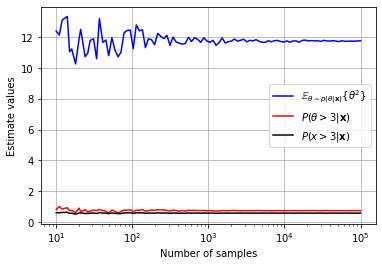

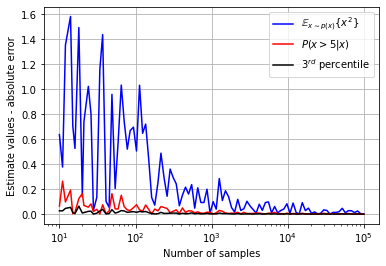

In [126]:
theta_0 = 0
sigma_0 = 5
b = 2

proposal_distribution = scistats.norm
proposal_scale = 2

iter_range = np.logspace(2, 6, 100, dtype = np.int32)

len_samples = []
estimate_mat = np.zeros((100, 3))

for cnt, n_iters in enumerate(iter_range):

    theta_start = 0
    
    samples, acc = MCMC(n_iters, 
                        Q2_data, 
                        theta_start, 
                        theta_0, 
                        sigma_0, 
                        b, 
                        proposal_distribution, 
                        proposal_scale, 
                        met_hastings = True, 
                        warming_period = 0.5, 
                        M_thinning = 5,
                       visualise = False)
    
    len_samples.append(len(samples))
    
    estimate_mat[cnt, 0] = np.mean(samples**2)
    estimate_mat[cnt, 1] = 1 - np.mean((samples <= 3))
    
    probability = np.zeros_like(samples)
    
    for cnt_theta, theta in enumerate(samples):
    
        #Sample the generative model
        local_samples = generative_model_method.rvs(loc = theta, scale = b, size = N_per_sample)

        probability[cnt_theta] = 1 - np.mean(local_samples <= 3)
    
    estimate_mat[cnt, 2] = np.mean(probability)

plt.figure()
plt.semilogx(len_samples, estimate_mat[:, 0], color = "b", label = r"$\mathbb{E}_{\theta \sim p(\theta \vert \mathbf{x})} \{ \theta^2 \}$")
plt.semilogx(len_samples, estimate_mat[:, 1], color = "r", label = r"$P(\theta > 3 \vert \mathbf{x})$")
plt.semilogx(len_samples, estimate_mat[:, 2], color = "k", label = r"$P(x > 3 \vert \mathbf{x})$")
plt.xlabel("Number of samples")
plt.ylabel("Estimate values")
plt.legend()
plt.savefig("./images/Q2g_1.pdf")
plt.grid()

plt.figure()
plt.semilogx(len_samples, np.abs((estimate_mat[:, 0] - estimate_mat[-1, 0])), color = "b", label = r"$\mathbb{E}_{x \sim p(x)} \{ x^2 \}$")
plt.semilogx(len_samples, np.abs((estimate_mat[:, 1] - estimate_mat[-1, 1])), color = "r", label = r"$P(x > 5 \vert x)$")
plt.semilogx(len_samples, np.abs((estimate_mat[:, 2] - estimate_mat[-1, 2])), color = "k", label = r"$3^{rd}$ percentile")
plt.xlabel("Number of samples")
plt.ylabel("Estimate values - absolute error")
plt.legend()
plt.savefig("./images/Q2g_2.pdf")
plt.grid()

In [127]:
estimate_mat[-1, :]

array([11.75355748,  0.73571   ,  0.57423201])

# Problem 3

## Load in the data

dict_keys(['__header__', '__version__', '__globals__', 'strain_measurements', 'stress_measurements_in_MPa'])
dict_keys(['__header__', '__version__', '__globals__', 'mean_of_posterior_MPa', 'covariance_of_posterior_MPa'])


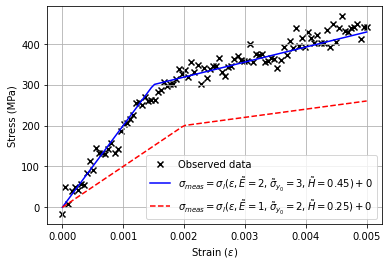

In [128]:
Q3_measurements = io.loadmat(r"G:\My Drive\Engineering\PhD\2022\MIL780\Block 3\Assignment\problem3_material_model_measurements.mat")
Q3_post_normal = io.loadmat(r"G:\My Drive\Engineering\PhD\2022\MIL780\Block 3\Assignment\problem3_partB_posterior_normal.mat")
Q3_post_normal_updated = io.loadmat(r"G:\My Drive\Engineering\PhD\2022\MIL780\Block 3\Assignment\problem3_partB_posterior_normal_updated.mat")

def normalise_parameters_method(E, yield_stress, plastic_modulus):
    
    E_norm = E / 1e11
    yield_norm = yield_stress / 1e8
    plastic_norm = plastic_modulus / 1e11
    
    return E_norm, yield_norm, plastic_norm

def scale_parameters_method(E, yield_stress, plastic_modulus):
    
    E_scale = E * 1e11
    yield_scale = yield_stress * 1e8
    plastic_scale = plastic_modulus * 1e11
    
    return E_scale, yield_scale, plastic_scale

def material_model(strain_input,scaled_parameters):

    e = strain_input

    E, yield_strength, H = scaled_parameters #scale_parameters_method(*scaled_parameters)

    E = 1E11 * E # in Pa
    yield_strength = 1E8 * yield_strength # in Pa
    H = 1E11 * H # in Pa

    h = lambda x: x > 0
    
    factor = e - yield_strength/E
    h_factor = h(factor)
    stress = E * e * (1 - h_factor) + (yield_strength + H * E/ (H + E) * (factor)) *  h_factor

    return stress / 1E6 # Stress in MPa

print(Q3_measurements.keys())
print(Q3_post_normal.keys())
strain = Q3_measurements['strain_measurements'][0, :]
stress = Q3_measurements['stress_measurements_in_MPa'][0, :]

plt.figure()
plt.scatter(strain, stress, color = "k", marker = "x", label = "Observed data")
plt.plot(strain, material_model(strain, normalise_parameters_method(200e9, 300e6, 45e9)), color = "b", linestyle = "-", label = r"$\sigma_{meas} = \sigma_{l}(\epsilon, \tilde{E} = 2, \tilde{\sigma}_{y_0} = 3, \tilde{H} = 0.45) + 0$")
plt.plot(strain, material_model(strain, normalise_parameters_method(100e9, 200e6, 25e9)), color = "r", linestyle = "--", label = r"$\sigma_{meas} = \sigma_{l}(\epsilon, \tilde{E} = 1, \tilde{\sigma}_{y_0} = 2, \tilde{H} = 0.25) + 0$")
plt.xlabel(r"Strain ($\epsilon$)")
plt.ylabel("Stress (MPa)")
plt.grid()
plt.legend()
plt.savefig("./images/Q3a.pdf")
plt.show()

## Q3a) PyMC implementation

In [25]:
import pymc3 as pm

### Define the model

In [26]:
def linear_regression(strain, stress, alphas = [3, 3, 3, 3], betas = [1, 1, 1, 1]):
    
    with pm.Model() as linear_model:

        #Define the priors
        _E = pm.Gamma("E_norm", alpha = alphas[0], beta = betas[0]) #Prior over E
        _yield = pm.Gamma("yield_norm", alpha = alphas[1], beta = betas[1]) #Prior over yield_stress
        _H = pm.Gamma("H_norm", alpha = alphas[2], beta = betas[2]) #Prior over plastic_modulus
        noise = pm.Gamma("noise", alpha = alphas[3], beta = betas[3]) #Prior over the noise
        
        #Define the generative model
        x_obs = pm.Normal(
        "x_obs",
        mu = material_model(strain, [_E, _yield, _H]),
        sigma = noise,
        observed=stress,
        )

    return linear_model

In [27]:
pymc_material_model = linear_regression(strain, stress)

In [28]:
#Check out the model
pymc_material_model.E_norm

E_norm ~ Gamma

In [29]:
#Check out the model
pymc_material_model.yield_norm

yield_norm ~ Gamma

In [30]:
#Check out the model
pymc_material_model.H_norm

H_norm ~ Gamma

In [31]:
#Check out the model
pymc_material_model.noise

noise ~ Gamma

In [32]:
#Check out the model
pymc_material_model.x_obs

x_obs ~ Normal

### Get samples and MAP

In [130]:
#with pymc_material_model:
#Sample the prior predictive distribution
prior = pm.sample_prior_predictive(samples = 5000, 
                                   model = pymc_material_model)

#Sample the posterior
posterior = pm.sample(draws = 5000, 
                      tune = 4000, 
                      model = pymc_material_model, 
                      discard_tuned_samples = True,
                     return_inferencedata=False,
                     cores = None)#Uses max available

#Sample the posterior predictive distribution
posterior_pred = pm.sample_posterior_predictive(trace = posterior, 
                                                model = pymc_material_model)

#Get the MAP estimate
map_estimate = pm.find_MAP(model = pymc_material_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 38 seconds.


### MAP estimate

In [131]:
#map_estimate = pm.find_MAP(model = pymc_material_model, maxeval=10000)
print(map_estimate)

norm_samples = np.array([map_estimate["E_norm"], map_estimate["yield_norm"], map_estimate["H_norm"]])
scaled_samples = scale_parameters_method(*norm_samples)

print("\n\nMAP estimate: \nYoung's Modulus : {:.3f} GPa\nYield stress: {:.3f} MPa\n Plastic modulus: {:.3f} GPa\nNoise: {:.3f}".format(scaled_samples[0] / 1e9, 
                                                          scaled_samples[1] / 1e6,
                                                          scaled_samples[2] / 1e9, map_estimate["noise"]))

{'E_norm_log__': array(0.64103132), 'yield_norm_log__': array(1.10192988), 'H_norm_log__': array(-0.61270477), 'noise_log__': array(2.77272101), 'E_norm': array(1.89843776), 'yield_norm': array(3.0099693), 'H_norm': array(0.54188321), 'noise': array(16.0021168)}


MAP estimate: 
Young's Modulus : 189.844 GPa
Yield stress: 300.997 MPa
 Plastic modulus: 54.188 GPa
Noise: 16.002


### Prior samples

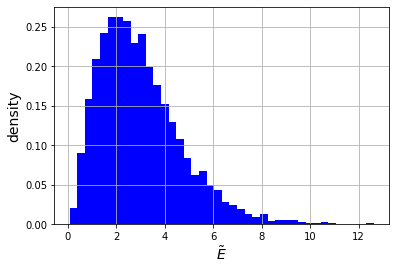

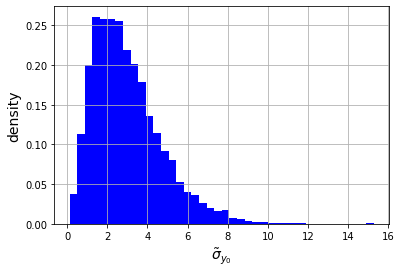

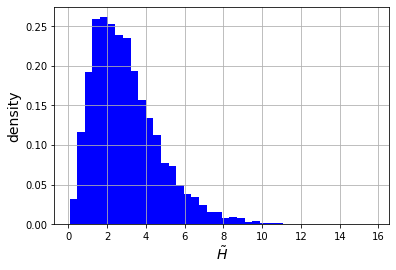

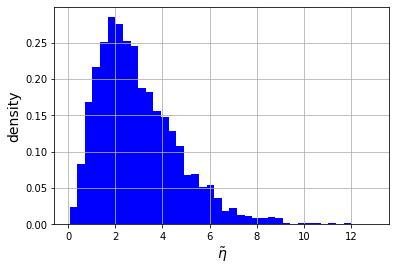

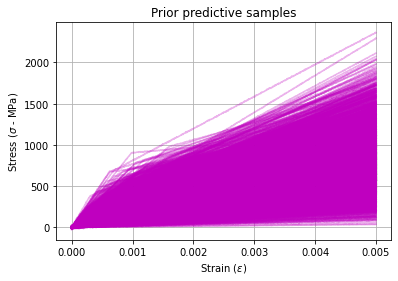

In [144]:
plt.figure()
plt.hist(prior["E_norm"], color = "b", density = True, bins = 40)
plt.xlabel(r"$\tilde{E}$", fontsize = 14)
plt.ylabel("density", fontsize = 14)
plt.grid()
plt.savefig("./images/Q3a_1.pdf")
plt.show()

plt.figure()
plt.hist(prior["yield_norm"], color = "b", density = True, bins = 40)
plt.xlabel(r"$\tilde{\sigma}_{y_{0}}$", fontsize = 14)
plt.ylabel("density", fontsize = 14)
plt.grid()
plt.savefig("./images/Q3a_2.pdf")
plt.show()

plt.figure()
plt.hist(prior["H_norm"], color = "b", density = True, bins = 40)
plt.xlabel(r"$\tilde{H}$", fontsize = 14)
plt.ylabel("density", fontsize = 14)
plt.grid()
plt.savefig("./images/Q3a_3.pdf")
plt.show()

plt.figure()
plt.hist(prior["noise"], color = "b", density = True, bins = 40)
plt.xlabel(r"$\tilde{\eta}$", fontsize = 14)
plt.ylabel("density", fontsize = 14)
plt.grid()
plt.savefig("./images/Q3a_4.pdf")
plt.show()

plt.figure()
plt.title("Prior predictive samples")
strain_plot = np.linspace(np.min(strain), np.max(strain), 1000)

for i in range(len(prior["E_norm"])):
    
    stress_plot = material_model(strain_plot, [prior["E_norm"][i],
                                                       prior["yield_norm"][i],
                                                       prior["H_norm"][i]])
    
    stress_plot += np.random.randn(len(stress_plot))* prior["noise"][i]
    
    plt.plot(strain_plot, stress_plot, color = "m", alpha = 0.3)
plt.xlabel(r"Strain ($\epsilon$)")
plt.ylabel(r"Stress ($\sigma$ - MPa)")
plt.grid()
plt.savefig("./images/Q3a_5.pdf")
plt.savefig("./images/Q3a_5.png")
plt.show()

### Posterior distributions

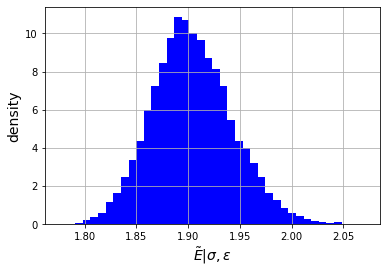

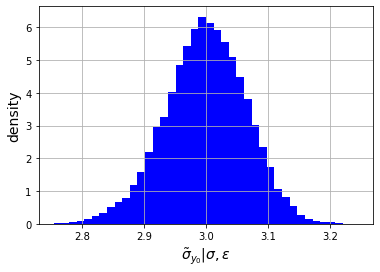

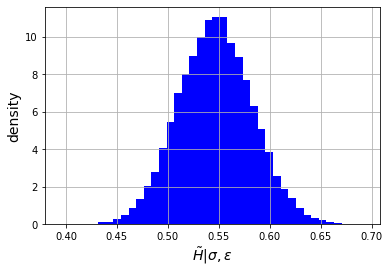

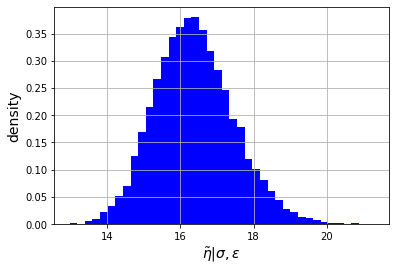

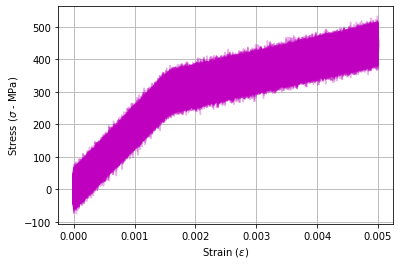

In [145]:
plt.figure()
plt.hist(posterior["E_norm"], color = "b", density = True, bins = 40)
plt.xlabel(r"$\tilde{E} \vert \sigma, \epsilon$", fontsize = 14)
plt.ylabel("density", fontsize = 14)
plt.grid()
plt.savefig("./images/Q3a_6.pdf")
plt.show()

plt.figure()
plt.hist(posterior["yield_norm"], color = "b", density = True, bins = 40)
plt.xlabel(r"$\tilde{\sigma}_{y_0} \vert \sigma, \epsilon$", fontsize = 14)
plt.ylabel("density", fontsize = 14)
plt.grid()
plt.savefig("./images/Q3a_7.pdf")
plt.show()

plt.figure()
plt.hist(posterior["H_norm"], color = "b", density = True, bins = 40)
plt.xlabel(r"$\tilde{H} \vert \sigma, \epsilon$", fontsize = 14)
plt.ylabel("density", fontsize = 14)
plt.grid()
plt.savefig("./images/Q3a_8.pdf")
plt.show()

plt.figure()
plt.hist(posterior["noise"], color = "b", density = True, bins = 40)
plt.xlabel(r"$\tilde{\eta} \vert \sigma, \epsilon$", fontsize = 14)
plt.ylabel("density", fontsize = 14)
plt.grid()
plt.savefig("./images/Q3a_9.pdf")
plt.show()

plt.figure()

strain_plot = np.linspace(np.min(strain), np.max(strain), 1000)

for i in range(len(posterior["E_norm"])):
    
    stress_plot = material_model(strain_plot, [posterior["E_norm"][i],
                                                       posterior["yield_norm"][i],
                                                       posterior["H_norm"][i]])
    
    stress_plot += np.random.randn(len(stress_plot))* posterior["noise"][i]
    
    plt.plot(strain_plot, stress_plot, color = "m", alpha = 0.3)
plt.xlabel(r"Strain ($\epsilon$)")
plt.ylabel(r"Stress ($\sigma$ - MPa)")
plt.grid()
plt.savefig("./images/Q3a_10.pdf")
plt.savefig("./images/Q3a_10.png")
plt.show()

In [37]:
#import arviz as az

#az.plot_trace(posterior, var_names=["E_norm", "yield_norm", "H_norm", "noise"], figsize = (10, 15));
#az.plot_energy(posterior)
#az.summary(posterior, round_to=2)

### Check the posterior covariance

In [143]:
X = np.vstack([posterior["E_norm"] * 1e11, posterior['yield_norm'] * 1e8, posterior['H_norm'] * 1e11]).T / 1e6

cov = np.cov(X, rowvar = False)

#with np.printoptions(suppress=False, formatter={'float_kind':'{:0.2f}'.format}):
    
print(np.mean(X, axis = 0), np.mean(posterior['noise']), "\n\n")
print(cov) #Units are MPa

print("")

print("\n\nMAP estimate: \nYoung's Modulus : {:.3f} GPa\nYield stress: {:.3f} MPa\n Plastic modulus: {:.3f} GPa\nNoise: {:.3f}".format(scaled_samples[0] / 1e9, 
                                                          scaled_samples[1] / 1e6,
                                                          scaled_samples[2] / 1e9, map_estimate["noise"]))

[190400.1572643     299.92543113  54681.86722043] 16.387052921533993 


[[ 1.50051001e+07 -1.22798791e+04  1.77793306e+06]
 [-1.22798791e+04  4.19284084e+01 -1.94636393e+04]
 [ 1.77793306e+06 -1.94636393e+04  1.30896745e+07]]



MAP estimate: 
Young's Modulus : 189.844 GPa
Yield stress: 300.997 MPa
 Plastic modulus: 54.188 GPa
Noise: 16.002


### Posterior predictive

(20000, 100)


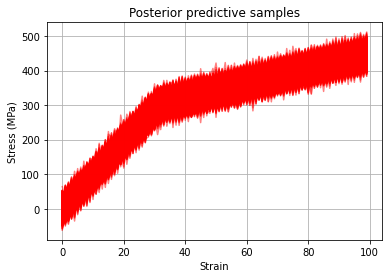

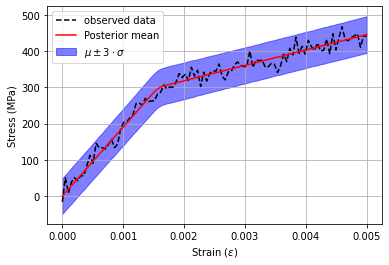

In [146]:
print(posterior_pred['x_obs'].shape)

plt.figure()
plt.title("Posterior predictive samples")
for i in range(posterior_pred['x_obs'].shape[0] // 2):
    plt.plot(posterior_pred["x_obs"][i, :], color = "r", alpha = 0.5)
plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.grid()
plt.savefig("./images/Q3a_11.pdf")
plt.savefig("./images/Q3a_11.png")
plt.show()
    
pp_mean = np.mean(posterior_pred["x_obs"], axis = 0)
pp_std = np.std(posterior_pred["x_obs"], axis = 0)
plt.figure()
plt.plot(strain, stress, color = "k", linestyle = "--", label = "observed data")
plt.plot(strain, pp_mean, color = "r", linestyle = "-", label = "Posterior mean")

plt.fill_between(strain, pp_mean - 3 * pp_std, pp_mean + 3 * pp_std, color = "b", alpha = 0.5, label = r"$\mu \pm 3 \cdot \sigma$")
plt.legend()
plt.xlabel(r"Strain ($\epsilon)$")
plt.ylabel("Stress (MPa)")
plt.grid()
plt.savefig("./images/Q3a_12.pdf")
plt.show()

### How do the parameters affect the results?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.882851606923619, but should be close to 0.8. Try to increase the number of tuning steps.



{'E_norm_log__': array(0.64091703), 'yield_norm_log__': array(1.1025516), 'H_norm_log__': array(-0.6153971), 'noise_log__': array(2.76860861), 'E_norm': array(1.89822081), 'yield_norm': array(3.01184124), 'H_norm': array(0.54042625), 'noise': array(15.9364448)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8792341096235569, but should be close to 0.8. Try to increase the number of tuning steps.



{'E_norm_log__': array(0.64101903), 'yield_norm_log__': array(1.1019996), 'H_norm_log__': array(-0.61300577), 'noise_log__': array(2.77226493), 'E_norm': array(1.89841443), 'yield_norm': array(3.01017915), 'H_norm': array(0.54172013), 'noise': array(15.99482023)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 28 seconds.



{'E_norm_log__': array(0.64112132), 'yield_norm_log__': array(1.10144095), 'H_norm_log__': array(-0.61059185), 'noise_log__': array(2.7759512), 'E_norm': array(1.89860864), 'yield_norm': array(3.00849801), 'H_norm': array(0.54302938), 'noise': array(16.05389014)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 29 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.643293460048231, but should be close to 0.8. Try to increase the number of tuning steps.



{'E_norm_log__': array(0.64122373), 'yield_norm_log__': array(1.10087621), 'H_norm_log__': array(-0.60815518), 'noise_log__': array(2.77968232), 'E_norm': array(1.89880308), 'yield_norm': array(3.00679947), 'H_norm': array(0.54435418), 'noise': array(16.11390106)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 29 seconds.



{'E_norm_log__': array(0.64132755), 'yield_norm_log__': array(1.10030496), 'H_norm_log__': array(-0.60569651), 'noise_log__': array(2.78345223), 'E_norm': array(1.89900023), 'yield_norm': array(3.00508233), 'H_norm': array(0.54569422), 'noise': array(16.17476375)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 28 seconds.



{'E_norm_log__': array(0.64143329), 'yield_norm_log__': array(1.09972716), 'H_norm_log__': array(-0.60321444), 'noise_log__': array(2.78726005), 'E_norm': array(1.89920104), 'yield_norm': array(3.00334647), 'H_norm': array(0.54705034), 'noise': array(16.23647171)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 28 seconds.



{'E_norm_log__': array(0.64153792), 'yield_norm_log__': array(1.09914293), 'H_norm_log__': array(-0.60071397), 'noise_log__': array(2.79111572), 'E_norm': array(1.89939975), 'yield_norm': array(3.00159234), 'H_norm': array(0.54841994), 'noise': array(16.29919499)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 28 seconds.



{'E_norm_log__': array(0.6416467), 'yield_norm_log__': array(1.09855344), 'H_norm_log__': array(-0.5981942), 'noise_log__': array(2.79501558), 'E_norm': array(1.89960639), 'yield_norm': array(2.99982346), 'H_norm': array(0.54980357), 'noise': array(16.36288361)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 28 seconds.



{'E_norm_log__': array(0.64721157), 'yield_norm_log__': array(1.09206716), 'H_norm_log__': array(-0.58430272), 'noise_log__': array(2.79999088), 'E_norm': array(1.91020692), 'yield_norm': array(2.98042872), 'H_norm': array(0.55749446), 'noise': array(16.44449672)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.7012438570388089, but should be close to 0.8. Try to increase the number of tuning steps.



{'E_norm_log__': array(0.09544426), 'yield_norm_log__': array(2.19720315), 'H_norm_log__': array(2.19720548), 'noise_log__': array(4.07128109), 'E_norm': array(1.1001475), 'yield_norm': array(8.99980713), 'H_norm': array(8.99982809), 'noise': array(58.6320274)}


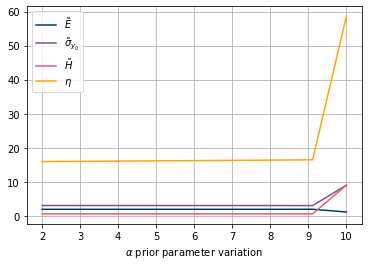

In [40]:
alpha_range = np.linspace(2, 10, 10)
Es = np.zeros_like(alpha_range)
yields = np.zeros_like(alpha_range)
Hs = np.zeros_like(alpha_range)
noises = np.zeros_like(alpha_range)

for cnt, alpha in enumerate(alpha_range):
    pymc_material_model_iter = linear_regression(strain, stress, alphas = [alpha] * 4, betas = [1] * 4)
    
    posterior_iter = pm.sample(draws = 5000, 
                      tune = 4000, 
                      model = pymc_material_model_iter, 
                      discard_tuned_samples = True,
                     return_inferencedata=True,
                     cores = 3)
    
    map_estimate_iter = pm.find_MAP(model = pymc_material_model_iter)
    
    Es[cnt] = map_estimate_iter['E_norm']
    yields[cnt] = map_estimate_iter['yield_norm']
    Hs[cnt] = map_estimate_iter['H_norm']
    noises[cnt] = map_estimate_iter['noise']

    print(map_estimate_iter)
    
plt.figure()
plt.plot(alpha_range, Es, color = "#003f5c", label = r"$\tilde{E}$")
plt.plot(alpha_range, yields, color = "#7a5195", label = r"$\tilde{\sigma}_{y_0}$")
plt.plot(alpha_range, Hs, color = "#ef5675", label = r"$\tilde{H}$")
plt.plot(alpha_range, noises, color = "#ffa600", label = r"$\eta$")
plt.legend()
plt.xlabel(r"$\alpha$ prior parameter variation")
plt.grid()
plt.savefig("./images/Q3a_13.pdf")
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 29 seconds.



{'E_norm_log__': array(0.09370303), 'yield_norm_log__': array(2.99121379), 'H_norm_log__': array(2.99911458), 'noise_log__': array(4.24820893), 'E_norm': array(1.09823355), 'yield_norm': array(19.90983411), 'H_norm': array(20.06776068), 'noise': array(69.97996109)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 29 seconds.



{'E_norm_log__': array(0.09362704), 'yield_norm_log__': array(2.58636327), 'H_norm_log__': array(2.58634194), 'noise_log__': array(4.23253196), 'E_norm': array(1.09815011), 'yield_norm': array(13.2813829), 'H_norm': array(13.28109954), 'noise': array(68.89144194)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 28 seconds.



{'E_norm_log__': array(0.09355157), 'yield_norm_log__': array(2.17606261), 'H_norm_log__': array(2.17395443), 'noise_log__': array(4.21040241), 'E_norm': array(1.09806723), 'yield_norm': array(8.8115434), 'H_norm': array(8.79298661), 'noise': array(67.38365052)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 28 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5559248179838738, but should be close to 0.8. Try to increase the number of tuning steps.



{'E_norm_log__': array(0.64120126), 'yield_norm_log__': array(1.10199274), 'H_norm_log__': array(-0.61261987), 'noise_log__': array(2.81994505), 'E_norm': array(1.89876041), 'yield_norm': array(3.01015851), 'H_norm': array(0.54192922), 'noise': array(16.7759288)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 28 seconds.



{'E_norm_log__': array(0.64115392), 'yield_norm_log__': array(1.10197723), 'H_norm_log__': array(-0.61265575), 'noise_log__': array(2.8066997), 'E_norm': array(1.89867054), 'yield_norm': array(3.01011182), 'H_norm': array(0.54190978), 'noise': array(16.55519089)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 28 seconds.



{'E_norm_log__': array(0.64108628), 'yield_norm_log__': array(1.10195177), 'H_norm_log__': array(-0.61268607), 'noise_log__': array(2.78795984), 'E_norm': array(1.89854211), 'yield_norm': array(3.0100352), 'H_norm': array(0.54189335), 'noise': array(16.24783772)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 28 seconds.



{'E_norm_log__': array(0.64099315), 'yield_norm_log__': array(1.10191379), 'H_norm_log__': array(-0.6127152), 'noise_log__': array(2.7620585), 'E_norm': array(1.89836531), 'yield_norm': array(3.00992087), 'H_norm': array(0.54187756), 'noise': array(15.83240035)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 28 seconds.



{'E_norm_log__': array(0.6408686), 'yield_norm_log__': array(1.10185723), 'H_norm_log__': array(-0.61273104), 'noise_log__': array(2.72728738), 'E_norm': array(1.89812887), 'yield_norm': array(3.00975063), 'H_norm': array(0.54186898), 'noise': array(15.29135104)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 28 seconds.



{'E_norm_log__': array(0.64070835), 'yield_norm_log__': array(1.10177522), 'H_norm_log__': array(-0.61271715), 'noise_log__': array(2.68215204), 'E_norm': array(1.89782472), 'yield_norm': array(3.00950382), 'H_norm': array(0.54187651), 'noise': array(14.61651474)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [noise, H_norm, yield_norm, E_norm]


Sampling 3 chains for 4_000 tune and 5_000 draw iterations (12_000 + 15_000 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.8826271957888417, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5988794305082447, but should be close to 0.8. Try to increase the number of tuning steps.



{'E_norm_log__': array(0.64050851), 'yield_norm_log__': array(1.10165902), 'H_norm_log__': array(-0.61264603), 'noise_log__': array(2.62565153), 'E_norm': array(1.89744551), 'yield_norm': array(3.00915413), 'H_norm': array(0.54191505), 'noise': array(13.81357124)}


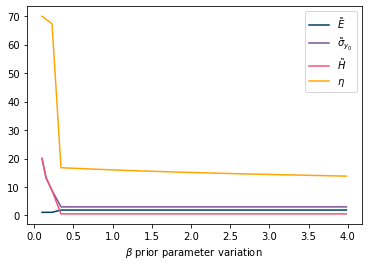

In [41]:
beta_range = np.logspace(-1, 0.6, 10)
Es = np.zeros_like(beta_range)
yields = np.zeros_like(beta_range)
Hs = np.zeros_like(beta_range)
noises = np.zeros_like(beta_range)

for cnt, beta in enumerate(beta_range):
    pymc_material_model_iter = linear_regression(strain, stress, alphas = [3] * 4, betas = [beta] * 4)
    
    posterior_iter = pm.sample(draws = 5000, 
                      tune = 4000, 
                      model = pymc_material_model_iter, 
                      discard_tuned_samples = True,
                     return_inferencedata=True,
                     cores = 3)
    
    map_estimate_iter = pm.find_MAP(model = pymc_material_model_iter)
    
    Es[cnt] = map_estimate_iter['E_norm']
    yields[cnt] = map_estimate_iter['yield_norm']
    Hs[cnt] = map_estimate_iter['H_norm']
    noises[cnt] = map_estimate_iter['noise']

    print(map_estimate_iter)
    
plt.figure()
plt.plot(beta_range, Es, color = "#003f5c", label = r"$\tilde{E}$")
plt.plot(beta_range, yields, color = "#7a5195", label = r"$\tilde{\sigma}_{y_0}$")
plt.plot(beta_range, Hs, color = "#ef5675", label = r"$\tilde{H}$")
plt.plot(beta_range, noises, color = "#ffa600", label = r"$\eta$")
plt.legend()
plt.xlabel(r"$\beta$ prior parameter variation")
plt.savefig("./images/Q3a_14.pdf")
plt.show()

## Q3b) General application and inference

In [42]:
def generative_model_likelihood(strain, stress, scaled_parameters, noise_sigma):
    
    stress_mean = material_model(strain,scaled_parameters)
    
    p1 = 1 / np.sqrt(2 * np.pi * noise_sigma**2)
    p2 = np.exp(-1/ (2 * noise_sigma**2) * (stress - stress_mean)**2)
    
    return p1 * p2

def generative_model_log_likelihood(strain, stress, scaled_parameters, noise_sigma):
    
    stress_mean = material_model(strain,scaled_parameters)
    
    p1 = -1/2 * np.log(2 * np.pi) 
    p2 = -1/2 * np.log(noise_sigma**2)
    p3 = -1/ (2 * noise_sigma**2) * (stress - stress_mean)**2
    
    return p1 + p2 + p3

def sample_generative_model(n_samples, strain, stress, scaled_parameters, noise_sigma):
    
    stress_mean = material_model(strain,scaled_parameters)
    
    return np.random.normal(loc = stress_mean, scale = noise_sigma, size = n_samples)

In [43]:
post_mean = Q3_post_normal["mean_of_posterior_MPa"][0, :]
post_cov = Q3_post_normal["covariance_of_posterior_MPa"]

post_mean_u = Q3_post_normal_updated["mean_of_posterior_MPa"][0, :]
post_cov_u = Q3_post_normal_updated["covariance_of_posterior_MPa"]

X = np.vstack([posterior["E_norm"] * 1e11, posterior['yield_norm'] * 1e8, posterior['H_norm'] * 1e11]).T  / 1e6

pymc_mean = np.mean(X, axis = 0)
pymc_cov = np.cov(X, rowvar = False)

mean_given = np.array([190000, 300, 55000, 18])
cov_given = np.array([[2 * 1e7, -1e4, 1e6, 0],
                      [-1e4, 30, -1e4, 0],
                      [1e6, -1e4, 1e7, 0],
                      [0, 0, 0, 1]])

print(mean_given, "\n\n", cov_given, "\n")

print(post_mean, "\n\n", post_cov, "\n")

print(pymc_mean, "\n\n", pymc_cov, "\n")

print(post_mean_u, "\n\n", post_cov_u, "\n")

#Sample the posterior
post_samples = np.random.multivariate_normal(post_mean, post_cov, size = 50000)
print(post_samples.shape)

#Sample the updated posterior
post_samples_u = np.random.multivariate_normal(post_mean_u, post_cov_u, size = 50000)
print(post_samples_u.shape)

[190000    300  55000     18] 

 [[ 2.e+07 -1.e+04  1.e+06  0.e+00]
 [-1.e+04  3.e+01 -1.e+04  0.e+00]
 [ 1.e+06 -1.e+04  1.e+07  0.e+00]
 [ 0.e+00  0.e+00  0.e+00  1.e+00]] 

[190000    300  55000] 

 [[ 2.e+07 -1.e+04  1.e+06]
 [-1.e+04  3.e+01 -1.e+04]
 [ 1.e+06 -1.e+04  1.e+07]] 

[190376.22092608    300.06201927  54591.76218586] 

 [[ 1.55644463e+07 -1.27127568e+04  1.82328159e+06]
 [-1.27127568e+04  4.13350692e+01 -1.87941796e+04]
 [ 1.82328159e+06 -1.87941796e+04  1.26393881e+07]] 

[1.9e+05 3.0e+02 5.5e+04 1.8e+01] 

 [[ 2.e+07 -1.e+04  1.e+06  0.e+00]
 [-1.e+04  3.e+01 -1.e+04  0.e+00]
 [ 1.e+06 -1.e+04  1.e+07  0.e+00]
 [ 0.e+00  0.e+00  0.e+00  1.e+00]] 

(50000, 3)
(50000, 4)


### What is the log-likelihood of the following model parameters E = 200.0 GPa, $\sigma_{y_0}$ = 300MPa, H = 45 GPa, and $\eta = 18$ given the the supplied stress $\sigma$ and strain $\epsilon$ measurements?

If the noise is known:
Log-likelihood: -437.306980446364
Likelihood: 1.2022408885773674e-190
1.2022408885773948e-190


C:\Users\ryanb.LAPTOP-4EHB9TVB\AppData\Local\Temp\ipykernel_22624\82116298.py:26: RuntimeWarning: divide by zero encountered in log
  plt.semilogx(noise_range, np.log(l_noise), "k--")


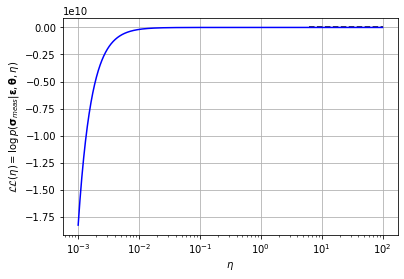

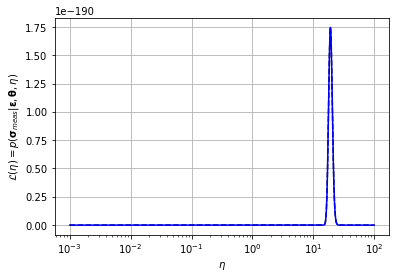

Noise that maximised LL: 19.023


In [151]:
E_ll = 200e9
yield_ll = 300e6
H_ll = 45e9
noise_ll = 18

norm_parameters = normalise_parameters_method(E_ll, yield_ll, H_ll)
ll_all_params = np.sum(generative_model_log_likelihood(strain, stress, norm_parameters, noise_ll))
l_all_params = np.product(generative_model_likelihood(strain, stress, norm_parameters, noise_ll))

print("If the noise is known:")
print("Log-likelihood: {}".format(ll_all_params))
print("Likelihood: {}".format(l_all_params))
print(np.exp(ll_all_params))

noise_range = np.logspace(-3, 2, 1000)

ll_noise  = np.zeros_like(noise_range)
l_noise = np.zeros_like(noise_range)

for cnt, noise in enumerate(noise_range):
    
    ll_noise[cnt] = np.sum(generative_model_log_likelihood(strain, stress, norm_parameters, noise))
    l_noise[cnt] = np.product(generative_model_likelihood(strain, stress, norm_parameters, noise))
    
plt.figure()
plt.semilogx(noise_range, np.log(l_noise), "k--")
plt.semilogx(noise_range, ll_noise, color = "b")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\mathcal{LL}(\eta) = \log p(\mathbf{\sigma}_{meas} \vert \mathbf{\epsilon}, \mathbf{\theta}, \eta)$")
plt.grid()
plt.savefig("./images/Q3b_1.pdf")
plt.show()

plt.figure()
plt.semilogx(noise_range, l_noise, "k--")
plt.semilogx(noise_range, np.exp(ll_noise), color = "b")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\mathcal{L}(\eta) = p(\mathbf{\sigma}_{meas} \vert \mathbf{\epsilon}, \mathbf{\theta}, \eta)$")
plt.grid()
plt.savefig("./images/Q3b_2.pdf")
plt.show()

LL_max_noise = noise_range[np.argmax(np.exp(ll_noise))]

print("Noise that maximised LL: {:.3f}".format(LL_max_noise))

### What is the 95% credible interval of $\sigma_{y_0} \vert \sigma, \epsilon$ in MPa? Note that $\sigma_{y_0} \vert \sigma, \epsilon$ denotes the posterior yield strength parameter. Show evidence of the calculation process.

In [45]:
#Get the yield_stress samples
post_yield_samples = post_samples[:, 1] * 1e6

lower = np.percentile(post_yield_samples, 2.5)
upper = np.percentile(post_yield_samples, 97.5)

print("Given:\n{:.3f} <= yield stress <= {:.3f} MPa".format(lower / 1e6, upper / 1e6))

#Get the yield_stress samples (PyMC)
post_yield_samples_pymc = posterior["yield_norm"] * 1e8

lower_pymc = np.percentile(post_yield_samples_pymc, 2.5)
upper_pymc = np.percentile(post_yield_samples_pymc, 97.5)
print("\nPyMC:")
print("{:.3f} <= yield stress <= {:.3f} MPa".format(lower_pymc / 1e6, upper_pymc / 1e6))


Given:
289.274 <= yield stress <= 310.702 MPa

PyMC:
286.801 <= yield stress <= 312.087 MPa


### Calculate $\mathbb{E} \{  H \vert \sigma, \epsilon \}$ in MPa. Show evidence of the calculate process.

In [46]:
#Get plastic samples (PyMC)
post_H_samples = post_samples[:, 2]

expectation = np.mean(post_H_samples) / 1e3

print("E(H | s, e) = {:.3f} GPa".format(expectation))
print("MAP estimate: {:.3f} GPa".format(post_mean[2] / 1e3))

#Get plastic samples
post_H_samples_pymc = posterior['H_norm'] 

expectation_pymc = np.mean(post_H_samples_pymc)* 1e11 / 1e9

print("\nPyMC:")
print("E(H | s, e) = {:.3f} GPa".format(expectation_pymc))
print("MAP estimate: {:.3f} GPa".format(map_estimate["H_norm"]* 1e11 / 1e9))

E(H | s, e) = 54.987 GPa
MAP estimate: 55.000 GPa

PyMC:
E(H | s, e) = 54.592 GPa
MAP estimate: 54.188 GPa


### The maximum stress in the mechanical component will be 250 MPa when using the material under consideration. What is the probability that the material will yield? Show evidence of the calculation process.

$P(\sigma_{y_0} \leq 250 \vert \sigma, \epsilon) = \mathbb{E}_{\sigma \sim p(\sigma_{y_0} \vert \sigma, \epsilon)}\{f_{250}(\sigma)\}$

Probability of yielding, based on posterior distribution: 0.0%
Probability of yielding, based on posterior distribution: 0.0%


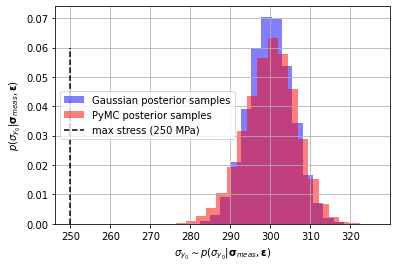

In [47]:
#Get the yield_stress samples
post_yield_samples = post_samples[:, 1] #MPa
max_stress = 250 #MPa

Prob = np.mean(post_yield_samples <= max_stress)
print("Probability of yielding, based on posterior distribution: {}%".format(Prob * 100))

#Get the yield_stress samples (PyMC)
post_yield_samples_pymc = posterior["yield_norm"] * 1e8 #Pa
max_stress = 250 * 1e6 #Pa

Prob_pymc = np.mean(post_yield_samples_pymc <= max_stress)
print("Probability of yielding, based on posterior distribution: {}%".format(Prob_pymc * 100))

plt.figure()
plt.hist(post_yield_samples, density = True, bins = 20, color = "b", label = "Gaussian posterior samples", alpha = 0.5)
plt.hist(post_yield_samples_pymc / 1e6, density = True, bins = 20, color = "r",  label = "PyMC posterior samples", alpha = 0.5)
plt.xlabel(r"$\sigma_{y_0} \sim p(\sigma_{y_0} \vert \mathbf{\sigma}_{meas}, \mathbf{\epsilon})$")
plt.ylabel(r"$p(\sigma_{y_0} \vert \mathbf{\sigma}_{meas}, \mathbf{\epsilon})$")
plt.plot([max_stress / 1e6, max_stress / 1e6], [0, 0.06], "k--", label = "max stress (250 MPa)")
plt.legend()
plt.grid()
plt.savefig("./images/Q3b_3.pdf")
plt.show()

### Given the historical data, what is the probability that the measured stress σ will be more than 200 MPa for a strain of 0.001? Show evidence of the calculation process.

$p(\sigma > 200 \vert \sigma, \epsilon) = 1 - p(\sigma \leq 200 \vert \sigma, \epsilon)$.

(1.9, 3.0, 0.55)


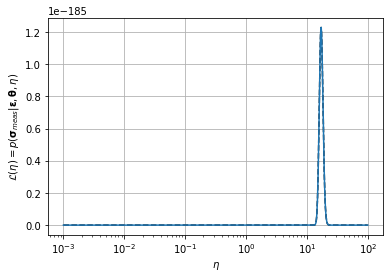

Noise that maximised the LL using the MAP parameters: 17.149
H1 0.28705692 0.28705692000000005


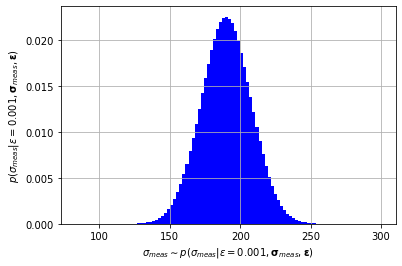

H2 0.28348921 0.28348921000000005


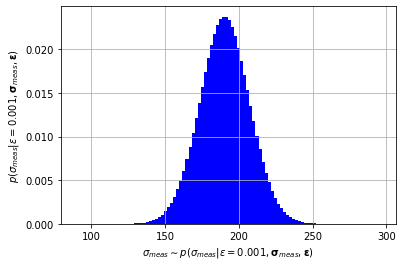

In [161]:
#Gaussian posterior approach

#Sample the posterior - done

#Get the MLE estimate for the noise based off the MAP values
norm_parameters = normalise_parameters_method(190000e6, 300e6, 55000e6)
print(norm_parameters)
noise_range = np.logspace(-3, 2, 1000)

ll_noise  = np.zeros_like(noise_range)
l_noise = np.zeros_like(noise_range)

for cnt, noise in enumerate(noise_range):
    
    ll_noise[cnt] = np.sum(generative_model_log_likelihood(strain, stress, norm_parameters, noise))
    l_noise[cnt] = np.product(generative_model_likelihood(strain, stress, norm_parameters, noise))

plt.figure()
plt.semilogx(noise_range, l_noise, "k--")
plt.semilogx(noise_range, np.exp(ll_noise))
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\mathcal{L}(\eta) = p(\mathbf{\sigma}_{meas} \vert \mathbf{\epsilon}, \mathbf{\theta}, \eta)$")
plt.grid()
plt.savefig("./images/Q3b_4.pdf")
plt.show()

MLE_max_noise = noise_range[np.argmax(np.exp(ll_noise))]
print("Noise that maximised the LL using the MAP parameters: {:.3f}".format(MLE_max_noise))

#Based off the posterior samples, generate samples from each posterior to get the probability of interest. 
prob_list = np.zeros(post_samples.shape[0])
x_sample_iter = []
n_samples = 10000
strain_val = 0.001
max_stress = 200


#Iterate through parameters
for i in range(post_samples.shape[0]):
    
    #Adjust parameters
    E_i, yield_i, H_i = post_samples[i, :] * 1e6
    
    scaled_parameters_i = normalise_parameters_method(E_i, yield_i, H_i)
    
    #Sample generative model
    post_stress_samples = sample_generative_model(n_samples, strain_val, stress, scaled_parameters_i, MLE_max_noise)
    
    #Determine probability
    prob_list[i] = 1 - np.mean(post_stress_samples <= max_stress)
    
    x_sample_iter.append(post_stress_samples)

x_plot = np.array(x_sample_iter).reshape(-1)

print("H1", np.mean(prob_list), 1 - np.mean(x_plot <= max_stress))


plt.figure()
plt.hist(x_plot, density = True, bins = 100, color = "b")
plt.xlabel(r"$\sigma_{meas} \sim p(\sigma_{meas} \vert \epsilon = 0.001, \mathbf{\sigma}_{meas}, \mathbf{\epsilon})$")
plt.ylabel(r"$p(\sigma_{meas} \vert \epsilon = 0.001, \mathbf{\sigma}_{meas}, \mathbf{\epsilon})$")
plt.grid()
plt.savefig("./images/Q3b_5.pdf")
plt.show()

    
#Correct PyMC approach
prob_list_PyMC = np.zeros(len(posterior["E_norm"]))
x_sample_iter = []

for i in range(len(posterior["E_norm"])):
    
    E_i = posterior["E_norm"][i]
    yield_i = posterior["yield_norm"][i]
    H_i = posterior["H_norm"][i]
    eta_i = posterior['noise'][i]
    
    scaled_parameters_i = [E_i, yield_i, H_i]
    
    #Sample generative model
    post_stress_samples = sample_generative_model(n_samples, strain_val, stress, scaled_parameters_i, eta_i)
    
    #Update
    prob_list_PyMC[i] = 1 - np.mean(post_stress_samples <= max_stress)
    
    #Store
    x_sample_iter.append(post_stress_samples)

x_plot = np.array(x_sample_iter).reshape(-1)

print("H2", np.mean(prob_list_PyMC), 1 - np.mean(x_plot <= max_stress))

plt.figure()
plt.hist(x_plot, density = True, bins = 100, color = "b")
plt.xlabel(r"$\sigma_{meas} \sim p(\sigma_{meas} \vert \epsilon = 0.001, \mathbf{\sigma}_{meas}, \mathbf{\epsilon})$")
plt.ylabel(r"$p(\sigma_{meas} \vert \epsilon = 0.001, \mathbf{\sigma}_{meas}, \mathbf{\epsilon})$")
plt.grid()
plt.savefig("./images/Q3b_6.pdf")
plt.show()
    


### Using the updated noise ($\eta = 18$)

Noise that maximised LL using the MAP parameters: 18.000
H1 0.29564059400000003 0.295640594


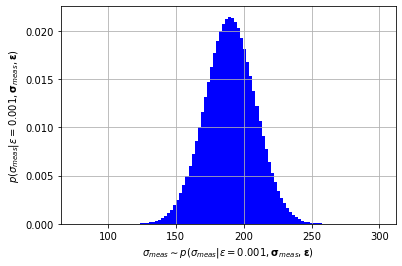

H1 0.29564059400000003 0.295640594


In [164]:
MLE_max_noise = 18#noise_range[np.argmax(np.exp(ll_noise))]
print("Noise that maximised LL using the MAP parameters: {:.3f}".format(MLE_max_noise))

#Based off the posterior samples, generate samples from each posterior to get the probability of interest. 
prob_list = np.zeros(post_samples.shape[0])
x_sample_iter = []
n_samples = 10000
strain_val = 0.001
max_stress = 200


#Iterate through parameters
for i in range(post_samples.shape[0]):
    
    #Adjust parameters
    E_i, yield_i, H_i = post_samples[i, :] * 1e6
    
    scaled_parameters_i = normalise_parameters_method(E_i, yield_i, H_i)
    
    #Sample generative model
    post_stress_samples = sample_generative_model(n_samples, strain_val, stress, scaled_parameters_i, MLE_max_noise)
    
    #Update
    prob_list[i] = 1 - np.mean(post_stress_samples <= max_stress)
    
    #Store
    x_sample_iter.append(post_stress_samples)

x_plot = np.array(x_sample_iter).reshape(-1)

print("H1", np.mean(prob_list), 1 - np.mean(x_plot <= max_stress))

plt.figure()
plt.hist(x_plot, density = True, bins = 100, color = "b")
plt.xlabel(r"$\sigma_{meas} \sim p(\sigma_{meas} \vert \epsilon = 0.001, \mathbf{\sigma}_{meas}, \mathbf{\epsilon})$")
plt.ylabel(r"$p(\sigma_{meas} \vert \epsilon = 0.001, \mathbf{\sigma}_{meas}, \mathbf{\epsilon})$")
plt.grid()
plt.savefig("./images/Q3b_7.pdf")
plt.show()

print("H1", np.mean(prob_list), 1 - np.mean(x_plot <= max_stress))

# Problem 4

The purpose of this question is to expose you to some applications of the concepts and theory that were covered in this course.

Select a field in engineering (e.g. heat transfer). It would be best if you can focus on a specific problem in the field. Identify and read through at least one journal paper that applies the theory covered in this course on an engineering problem. Ideally, the methods are applied on experimental data. Summarise in your own words the problem addressed in the paper(s) and how the methods (e.g. MCMC, maximum likelihood) were used to solve the problem. Discuss why specific decisions were made (e.g. why the specific Bayesian sampling method was selected, why specific software was used, how the prior was selected) and how the results are summarised.

How to get good marks:
In addition to the requirements of the previous category, the ideas are demonstrated on the problem covered in a paper (e.g. for example, if the paper uses a finite element heat transfer model as part of the inference process, you can simplify the problem to a one-dimensional heat transfer problem and generate your own experimental data to demonstrate the ideas). Some bonus marks might be awarded for critical investigations that combine different aspects covered in this course (e.g. the influence of model errors, comparison of different estimation/inference procedures). NB: The previous problem in this assignment focused on a simplified case of material calibration. It will be inadequate to redo the previous question on the same or similar problem (e.g. using a different material model) here.

There is a shaft encoder with $N$ sections used to record $M$ revolutions of the shaft. 

Assumptions:
- Each shaft section distance remains constant for all M revolutions.
- The sum of the $N$ sections add up to one ($2\pi$).
- The IAS between zero-crossing times can be expressed as a second order polynomial.
- The IAS is a continuous function throughout time. So no abrupt jumps in the IAS are allowed.

